In [1]:
# Set directory
import os
%cd ../

/Users/gregoryyampolsky/Downloads/RentEstimateProject


In [2]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
from src import preprocessing
from src.modeling import Modeler
import joblib
from pathlib import Path
from datetime import datetime
import shap
import numpy as np
import seaborn as sns


ModuleNotFoundError: No module named 'shap'

In [ ]:
#read the csv
df = pd.read_csv('data/TrainingSet.csv')
print(df.shape)
df.head()

(274075, 8)


,Close Date,Close Price,Latitude,Longitude,Bedrooms,Bathrooms,Square Feet,Year Built
0,12/17/2024,4800.0,26.257621,-81.711571,4,3.0,2259,2004
1,12/17/2024,3700.0,34.041742,-84.044686,5,6.0,2951,2002
2,12/17/2024,2400.0,33.205474,-96.664503,4,2.0,1788,2000
3,12/17/2024,1770.0,27.756995,-82.648477,3,1.0,944,1955
4,12/17/2024,1995.0,32.627490,-97.328963,3,2.0,1360,2010


In [ ]:
final_df = preprocessing.preprocess_data(df)
final_df.head()

In [ ]:
target_col = "Close Price"  
Modeler=Modeler(final_df, target_col)
Modeler.train_test_split(0.3)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor


models = {
    # linear regression
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {}
    },
    # decision tree 
    'decision_tree': {
        'model': DecisionTreeRegressor(random_state=42),
        'params': {
            'model__max_depth': [None, 10, 20],
            'model__min_samples_split': [2, 5, 10]
        }
    },
    # hist gradient boosting
    'HistGradientBoostingRegressor': {
        'model': HistGradientBoostingRegressor(random_state=42),
        'params': {
            'model__max_depth': [None, 10, 20],
            'model__min_samples_leaf': [2, 5, 10]
        }
    },
    # xgboost (slim grid for speed)
    'XGBoost': {
        'model': XGBRegressor(
            tree_method='hist',
            random_state=42,
            n_estimators=600,           
            learning_rate=0.06,        
            subsample=0.8,
            colsample_bytree=0.8,
            max_bin=128,               
            n_jobs=-1
        ),
        'params': {
            'model__objective': ['reg:squarederror'],     # single objective to reduce combos
            'model__max_depth': [4, 6],                   # fewer, shallower trees
            'model__min_child_weight': [3, 6],            # regularization via min child weight
            'model__gamma': [0, 1],                       # split loss threshold
            'model__reg_alpha': [0, 0.01],                # L1
            'model__reg_lambda': [1, 10]                  # L2
        }
    },
    # ANN 
    'ANN': {
        'model': MLPRegressor(
            random_state=42,
            max_iter=400,
            early_stopping=True,
            n_iter_no_change=5,
            tol=1e-3
        ),
        'params': {
            'model__hidden_layer_sizes': [(64,), (64, 32)],
            'model__activation': ['relu'],
            'model__learning_rate_init': [1e-3, 5e-4],
            'model__alpha': [1e-4, 1e-3],
            'model__batch_size': [128]
        }
    }
}

results = Modeler.model_evals(models=models)
results


  0%|          | 0/5 [00:00<?, ?it/s]

Training LinearRegression...


/Users/gregoryyampolsky/Downloads/RentEstimateProject/src/modeling.py:92: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.results_df = pd.concat([self.results_df, new_row], ignore_index=True)
 20%|██        | 1/5 [00:01<00:07,  1.90s/it]

________________________________________
Training decision_tree...


 40%|████      | 2/5 [00:08<00:13,  4.42s/it]

________________________________________
Training HistGradientBoostingRegressor...


 60%|██████    | 3/5 [00:15<00:11,  5.73s/it]

________________________________________
Training XGBoost...


 80%|████████  | 4/5 [00:55<00:19, 19.14s/it]

________________________________________
Training ANN...


100%|██████████| 5/5 [01:55<00:00, 23.07s/it]

________________________________________


,Model Name,Best Parameters,Training_Latency,Train_MSE,Test_MSE,TrainR2,TestR2
3,XGBoost,"{'model__gamma': 0, 'model__max_depth': 6, 'mo...",1.467239,140395.862975,177685.955236,0.789397,0.733566
2,HistGradientBoostingRegressor,"{'model__max_depth': None, 'model__min_samples...",2.181638,176416.775909,192623.378866,0.735364,0.711168
4,ANN,"{'model__activation': 'relu', 'model__alpha': ...",17.050192,227100.172297,233305.017996,0.659336,0.650167
1,decision_tree,"{'model__max_depth': 10, 'model__min_samples_s...",0.896651,200386.988743,246487.575425,0.699407,0.630400
0,LinearRegression,{},0.376583,386846.183132,381285.871252,0.419707,0.428275


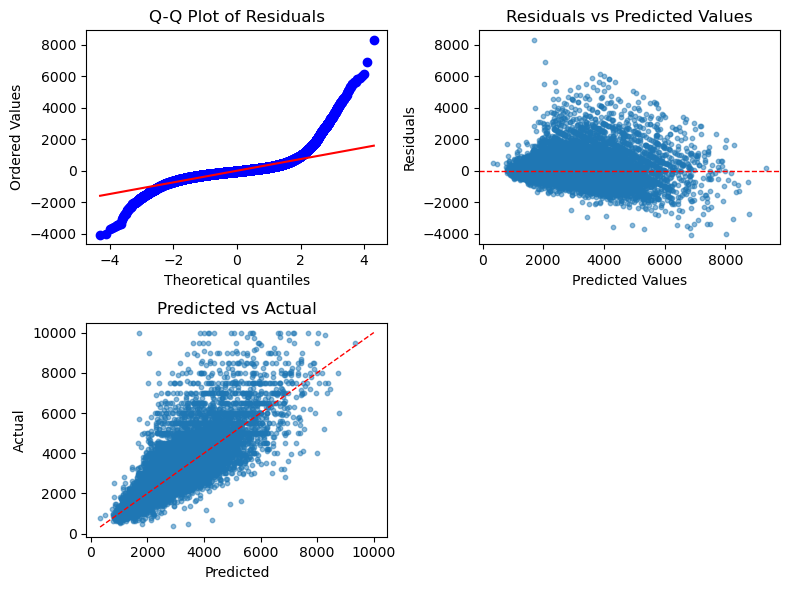

Residuals stats:
mean: 0.5810274831295541, std: 421.53028205567045, skew: 2.8610786390470335, kurtosis: 28.297144523782936


In [ ]:
# Compact diagnostics: 2 plots on the first row, 1 on the next
import scipy.stats as stats
import matplotlib.pyplot as plt

best_model = Modeler.best_model
y_pred = best_model.predict(Modeler.X_test)
residuals = Modeler.y_test - y_pred

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
ax1, ax2 = axes[0]
ax3, ax4 = axes[1]

# Q-Q plot (top-left)
stats.probplot(residuals, dist="norm", plot=ax1)
ax1.set_title("Q-Q Plot of Residuals")

# Residuals vs Predicted (top-right)
ax2.scatter(y_pred, residuals, alpha=0.5, s=10)
ax2.axhline(0, color='red', linestyle='--', linewidth=1)
ax2.set_xlabel("Predicted Values")
ax2.set_ylabel("Residuals")
ax2.set_title("Residuals vs Predicted Values")

# Predicted vs Actual (bottom-left)
ax3.scatter(y_pred, Modeler.y_test, alpha=0.5, s=10)
low = float(min(Modeler.y_test.min(), y_pred.min()))
high = float(max(Modeler.y_test.max(), y_pred.max()))
ax3.plot([low, high], [low, high], 'r--', linewidth=1)
ax3.set_xlabel("Predicted")
ax3.set_ylabel("Actual")
ax3.set_title("Predicted vs Actual")

# Hide unused bottom-right subplot
ax4.axis('off')

plt.tight_layout()
plt.show()
print('Residuals stats:')
print(f"mean: {residuals.mean()}, std: {residuals.std()}, skew: {residuals.skew()}, kurtosis: {residuals.kurtosis()}")

In [ ]:
Modeler.save_models()

Models saved to models/
Model results saved to models/model_results.csv


In [ ]:
Modeler.train_final_model()

Final model saved to models/final_model.joblib


In [ ]:
# Load final (best) model from disk and generate predictions on test set

test_path='data/TestSet.csv'
print(f"Reading test data from: {test_path}")
raw_test_df = pd.read_csv(test_path)
print(raw_test_df.head())

# Preprocess test data (same function used for training)
processed_test_df = preprocessing.preprocess_data(raw_test_df)
# Load best model
best_pipeline = joblib.load('models/final_model.joblib')
# Predict
preds = best_pipeline.predict(processed_test_df)
# Assemble output
output_df = raw_test_df.copy()
output_df['calculated Market Rent'] = preds
export_dir = Path('data/exports')
export_dir.mkdir(parents=True, exist_ok=True)
stamp = datetime.now().strftime('%Y%m%d_%H%M%S')
export_file = export_dir / f"final_predictions_{stamp}.csv"
output_df.to_csv(export_file, index=False)
print(f"Predictions written to {export_file} (rows={len(output_df)})")

Reading test data from: data/TestSet.csv
    Latitude   Longitude  Bedrooms  Bathrooms  Square Feet  Year Built
0  33.615438 -112.065775         4        2.0         2489        1985
1  29.755359  -95.781869         3        2.0         2204        1978
2  25.996436  -80.253141         2        2.0         1355        1982
3  39.911228  -83.093273         4        3.0         1861        2002
4  33.442062 -112.278588         4        2.0         1866        2004
Predictions written to data/exports/final_predictions_20251109_201345.csv (rows=10000)
Predictions written to data/exports/final_predictions_20251109_201345.csv (rows=10000)


In [ ]:
# SHAP feature importance and beeswarm plot (robust to different model types)


import shap


import numpy as np


import seaborn as sns


import matplotlib.pyplot as plt


import pandas as pd




# 1) Sample rows to keep it quick (works for tree and model-agnostic explainers)
n_sample = min(200, len(processed_test_df))
X_sample = processed_test_df.sample(n_sample, random_state=42)


# 2) Try to get the underlying estimator if the loaded object is a Pipeline
base_estimator = best_pipeline
try:
    if hasattr(best_pipeline, "steps"):
        # last step in a sklearn Pipeline is typically the estimator
        base_estimator = best_pipeline.steps[-1][1]
    elif hasattr(best_pipeline, "named_steps") and len(best_pipeline.named_steps):
        base_estimator = list(best_pipeline.named_steps.values())[-1]
except Exception:
    base_estimator = best_pipeline


# 3) Build an explainer
explainer = None
shap_values = None
is_tree_explainer = False
try:
    # Prefer fast TreeExplainer for XGBoost/GBDT-like models
    if hasattr(base_estimator, "get_booster") or "xgboost" in str(type(base_estimator)).lower():
        explainer = shap.TreeExplainer(base_estimator)
        shap_values = explainer.shap_values(X_sample)  # ndarray (n_samples, n_features) for regression
        is_tree_explainer = True
    else:
        raise ValueError("Not a tree-based estimator; falling back to model-agnostic explainer.")
except Exception:
    # Model-agnostic: explain the pipeline's predict function on the sampled data
    explainer = shap.Explainer(best_pipeline.predict, X_sample)
    shap_values = explainer(X_sample)  # shap.Explanation object


# 4) Beeswarm (preferred) with graceful fallback to bar chart
plotted = False
try:
    if not is_tree_explainer:
        # shap_values is an Explanation; use the modern plots API
        shap.plots.beeswarm(shap_values, max_display=15, show=False)
        plt.title("SHAP Beeswarm (Top 15)")
        plt.tight_layout()
        plt.show()
        plotted = True
    else:
        # TreeExplainer path returns ndarray; use summary_plot for a beeswarm
        shap.summary_plot(shap_values, X_sample, show=False)
        plt.title("SHAP Beeswarm (TreeExplainer)")
        plt.tight_layout()
        plt.show()
        plotted = True
except Exception:
    plotted = False


# 5) Always produce a compact horizontal bar chart as a clear importance view
try:
    if is_tree_explainer:
        values_matrix = np.asarray(shap_values)  # ndarray
        feature_names = list(X_sample.columns)
    else:
        # Explanation object
        values_matrix = np.asarray(getattr(shap_values, "values", shap_values))
        feature_names = getattr(shap_values, "feature_names", list(X_sample.columns))
    mean_abs_shap = np.abs(values_matrix).mean(axis=0)
    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Mean |SHAP|": mean_abs_shap
    }).sort_values(by="Mean |SHAP|", ascending=False)


    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(x="Mean |SHAP|", y="Feature", data=importance_df.head(20), palette="bwr")
    ax.set_title("Feature Importance (mean |SHAP|)")
    ax.set_xlabel("Average |SHAP value|")
    ax.set_ylabel("")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Could not compute bar chart of SHAP importances:", e)

ModuleNotFoundError: No module named 'shap'